# Business Question 1:

### Business Question 1: Code:

In [1]:
#Libraries used during whole notebook
import requests
import math
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
from wordcloud import WordCloud
from IPython.core.display import display, HTML

In [2]:
#Funcitons below are for common purposes, mainly actions with API requests

In [25]:
#Main function for calling the API to retrieve JSON
def call_api_with(url_extension, wait = True): #ask to wait to obey API request/time restriction
    #This is my api key
    your_company_house_api_key = "7c16c518-3fb5-4423-b8c8-0bf185b4ea36"  
    login_headers = {"Authorization": your_company_house_api_key}
    #Making a request based on the given url
    url = f"https://api.companieshouse.gov.uk/{url_extension}"
    res = requests.get(url, headers = login_headers)
    if not wait: #if wait is not needed
        return res.json()
    if res.status_code == 200: #if successful proceed with outcome
        return res.json()
    else: #if not wait and repeat again
        time.sleep(5)
        return call_api_with(url_extension)

In [26]:
#Search companies with specific query / keyword
def search_for_companies_with_query(query, number_of_companies = 100):
    # for simplicity round up the number of returned companies to the nearest hundred. eg. 130 becomes 200
    page_size = 100
    number_of_pages = math.ceil(number_of_companies / page_size) #round up
    companies = []
    for page_index in range(number_of_pages):
        #Prepare url for request to get companies at specified page
        url = f"search/companies?q={query}&items_per_page={page_size}&start_index={page_index * page_size}"
        companies += call_api_with(url).get('items', [])
    return companies[:number_of_companies]

In [27]:
#Get all persons with significant control from company based on company number
def all_persons_in_company(company_number):
    url = f"company/{company_number}/persons-with-significant-control"
    return call_api_with(url, wait = False).get('items', [])

In [28]:
#Get all people from the list of companies
def people_in_companies(companies):
    people = []
    count = 0 #start counting number of requests
    #Get ids of companies
    company_ids = [company['company_number'] for company in companies if 'company_number' in company]
    for iid in company_ids:
        #Get people information by company id
        people += all_persons_in_company(iid)
        count += 1 #add to counter
        #if it reaches 10 requests wait for 5 sec, so API limit of 600 requests for 5 min is obeyed
        if count == 10:
            time.sleep(5)
            count = 0 #reset counter
    return people

In [29]:
#Request to get company data based on company number
def data_for_company(company_number):
    url = f"company/{company_number}"
    return call_api_with(url)

In [30]:
#Get full info for companies by thier company_number
def detailed_info_about_companies_with_ids(companies_numbers):
    results = []
    for company_number in companies_numbers:
        results.append(data_for_company(company_number))
    return results

In [31]:
#Get full info for companies by search query
def detailed_info_about_companies_with_name(query, number_of_companies = 100):
    companies = search_for_companies_with_query(query, number_of_companies)
    ids = [company['company_number'] for company in companies if 'company_number' in company]
    return detailed_info_about_companies_with_ids(ids)    

In [10]:
#This cell is just to make all figures centered
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [11]:
#This cell is just to make the full screen of the code
display(HTML("<style>.container { width:100% !important; }</style>"))

In [12]:
#Funcitons below were made for specific purposes, each are explained

In [13]:
#Filter only active companies
def filter_active(companies):
    return [company for company in companies if 'company_status' in company and company['company_status'] == 'active']

In [14]:
#Count number of companies in each city
def count_by_city(companies):
    cities = [company['registered_office_address']['locality'] for company in companies if 'locality' in company['registered_office_address']]
    city_count = [(city, cities.count(city)) for city in set(cities)]
    city_count.sort(key = lambda x: x[1], reverse = True)
    return city_count

In [15]:
#Prepare data for a pie chart with specified number of pieces
def prep_for_pie(counts, pieces = 5, sort = False):
    count_dict = dict(counts[:pieces - 1]) #take only largest numbers
    #Remaining numbers will be included in Other
    count_dict['Other'] = 0 
    for i in counts[pieces - 1:]:
        count_dict['Other'] += i[1]
    #Sort the values if specified
    if sort:
        count_dict = dict(sorted([each for each in count_dict.items()], key = lambda x: x[1], reverse = True))
    return count_dict

In [16]:
#Preprocess data for business question 1: filter only active, count companies in different cities, prepare count for pie chart
def all_steps(companies):
    return prep_for_pie(count_by_city(filter_active(companies)))

In [17]:
#Getting detailed data for searched companies related to hotel and hostel
hotel_det = detailed_info_about_companies_with_name('hotel', number_of_companies = 1000)
hostel_det = detailed_info_about_companies_with_name('hostel', number_of_companies = 1000)

In [18]:
#Put data into preprocessing and calculate total values of hotels and hostels
act_hotel_cities = all_steps(hotel_det)
act_hostel_cities = all_steps(hostel_det)
print('obtained', sum(act_hotel_cities.values()),'active hotels')
print('obtained', sum(act_hostel_cities.values()), 'active hostels')

obtained 473 active hotels
obtained 163 active hostels


In [19]:
#Making figure of pie chart
fig1 = figure(figsize = (18, 6), dpi = 80)
explode = [0.2, 0.1, 0.1, 0.1, 0.1]
colors = ['tab:orange', 'm', 'tab:olive', 'tab:cyan', 'lightsteelblue']
plt.subplot(1, 2, 1)
plt.pie(x = act_hotel_cities.values(), autopct = '%1.1f%%', explode = explode, colors = colors, labels = act_hotel_cities.keys(), shadow = True, startangle = 70)
plt.title('Active Hotels locations')
plt.subplot(1, 2, 2)
plt.pie(x = act_hostel_cities.values(), autopct = '%1.1f%%', explode = explode, colors = colors, labels = act_hostel_cities.keys(), shadow = True, startangle = 70)
plt.title('Active Hostel locations')
plt.close()

### Business Question 1: Mini-report and visualisation:

**Case Problem:** The client plans to open a big restaurant in one of the cities of UK. The design and theme of restaurant is specialized for tourists. Besides rent price and competitors, the client is considering tourist popularity of cities to select the location. The task is to assess UK cities in terms of low-budget and high-budget tourism popularity.<br/><br/>
The popularity was assessed indirectly by measuring quantity of operating hotels and hostels throughout cities of UK. During analysis 473 hotels (representing high-budget tourism) and 163 hostels (representing low-budget tourism) were obtained by API search. All companies are officially registered and has an active status (not dissolved). Quarter of both hotels and hostels are located in London, representing the biggest number among cities. While its nearest competitor (Edinburgh) embrace only around 3% and 5% of hotels and hostels respectively.<br/><br/>
High concentration of active hotels and hostels in London shows satisfied demand of tourists on accommodation and therefore popularity of London in both high-budget and low-budget tourism. Moreover, the results demonstrate that the distribution of the rest of hotels and hostels are highly fragmented, meaning there is no feasible difference in popularity among other cities of UK. Therefore the analysis suggests London as the distinctively popular city in UK.

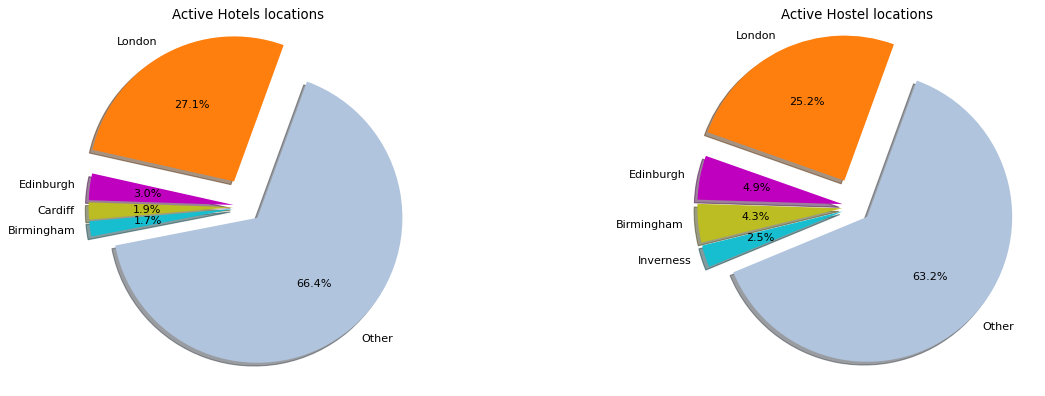

In [20]:
fig1

# Business Question 2:

### Business Question 2: Code:

In [17]:
#Calculate the age of a person
def get_age(person):
    #If no date of birth specified - omit
    if 'date_of_birth' not in person:
        return None
    #Get year and month of birth
    year = person['date_of_birth']['year']
    month = person['date_of_birth']['month']
    #Calculate the age
    age = 2021 - year
    #Deduct one year if the birthday still haven`t happened in this year
    if month == 12:
        age -= 1
    return age

In [18]:
def remove_from_dic_by_count(dic, treshold = 10):
    drop = [x for x in dic if len(dic[x]) < treshold]
    for each in drop:
        del dic[each]
    return dict(sorted([item for item in all_shares.items()], key = lambda x: x[0]))

In [48]:
#Get detailed info of toys companies and filter only active
toys_det = detailed_info_about_companies_with_name('toy', number_of_companies = 1000)
toys_act = filter_active(toys_det)
len(toys_act)

536

In [49]:
#Get people in filtered toy companies
toys_people = people_in_companies(toys_act)

In [33]:
#Get ages of shareholders, categorized by gender and type of control
women_shares = []
men_shares = []
all_shares = {}
for person in toys_people:
    age = get_age(person) #get age of each person
    if not age:
        continue #omit those with no specified birthday
    shares = person['natures_of_control'] #get shares of the perosn
    for share in shares:
        #Consider only owners of shares
        if 'ownership-of-shares' not in share:
            continue
        #Add age to total shareholders 
        if share in all_shares:
            all_shares[share].append(age)
        else:
            all_shares[share] = [age]
        #Add ages to shareholders by gender
        if 'mrs' in person['name'].lower():
            women_shares.append(age)
        elif 'mr' in person['name'].lower():
            men_shares.append(age)
print(f'{len(women_shares)} shareholders are women in toy business')
print(f'{len(men_shares)} shareholders are men in toy business')

109 shareholders are women in toy business
346 shareholders are men in toy business


In [34]:
#Removing types of shares w/ less than 10 shareholders
all_shares = remove_from_dic_by_count(all_shares)

In [35]:
#Making figure of violin chart
fig2 = plt.figure(figsize = (20, 6))
gendr = fig2.add_subplot(1, 2, 1)
gendr.set_ylabel('Age', fontsize = 15)
gendr.violinplot([women_shares, men_shares])
gendr.set_yticks(range(0, 100, 10))
gendr.set_xticks([1, 2])
gendr.set_xticklabels(['Women', 'Men'], fontsize = 15)
typ = fig2.add_subplot(1, 2, 2)
typ.violinplot([all_shares[each] for each in all_shares])
typ.set_yticks(range(0, 100, 10))
typ.set_xticks(range(1, len(all_shares) + 1))
typ.set_xticklabels(list(all_shares.keys()), fontsize = 15, rotation = 15)
plt.suptitle('Shareholders` age distribution', fontsize = 20)
plt.close()

### Business Question 2: Mini-report and visualisation:

**Case Problem:** The client wants to enter the toy business with introduction of new concepts. She thinks that current toy shops and manufacturers in UK became more focused on commercial part forgetting about the joy children will get from their products. She claims that the toy industry needs correction by young and creative look. The task is to investigate whether old-fashioned perspective of previous generation is the real situation in current toy industry.<br/><br/>
The analysis was conducted by searching companies related to toys by API search. During the search 536 active (not dissolved) companies were obtained. The owners in the face of main shareholders of these companies were then analyzed.<br/><br/>
The results showed that mainly owners of toy companies have age between 30 and 50 years, with the highest number of owners at age around 40. This trend was observed for both women and men, as well as for different control of shares. This means that the owner of company under 30 is a rare situation in toy industry. The analysis suggests that the dominance of previuos generation in toy industry of UK is the real case.

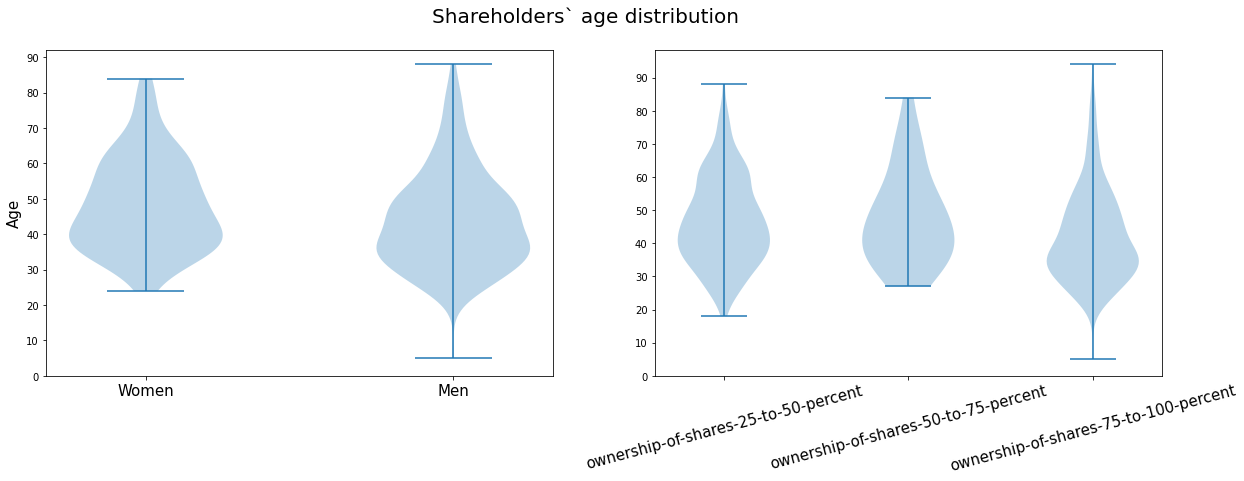

In [36]:
fig2

# Business Question 3:

### Business Question 3: Code:

In [40]:
#Filter companies by sic code
def filter_by_sic(companies, sic):
    res = []
    for company in companies:
        if 'sic_codes' not in company: #omit companies w/ no sic code
            continue
        for code in company['sic_codes']: 
            #if the company has the code add it and continue with another one
            if code in sic:
                res.append(company)
                break
    return res

In [41]:
#Get companies associated with halal
halal_det = detailed_info_about_companies_with_name('halal', number_of_companies = 1000)

In [42]:
#sic codes associated w/ retail sale
sic = ['47220', '56290', '56103', '47190', '47110', '47290']
halal_retail = filter_by_sic(halal_det, sic)
len(halal_retail)

418

In [44]:
#Get people in halal retailers
halal_people = people_in_companies(halal_retail)

In [45]:
#Get nationalities of those people
nations = [person['nationality'] for person in halal_people if 'nationality' in person]

In [46]:
#Making figure of word cloud
frequencies = Counter(nations)
cloud = WordCloud(width = 800, height = 400, max_font_size = 160, colormap = "hsv").generate_from_frequencies(frequencies)
fig3 = plt.figure(figsize = (16,12))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.close()

### Business Question 3: Mini-report and visualisation:

**Case problem:** The client is the halal meat retailer. He is from Turkey, where he has a chain of meat retail stores. Now he wants to expand his business and open a store in UK. The store will have Turkish specific products, such as Turkish sausages. The task is to investigate UK market of halal meat retailers.<br/><br/>
By searching companies associated with halal via API search it was found 418 companies in retail industry associated with halal. Among all the owners and other people of significant control in obtained companies there were found many nationalities. Most of the people were British, Pakistani, Afghan, Bangladeshi and Italian. None of the obtained people was Turkish.<br/><br/>
The analysis shows well developed market of halal meat retailers in UK. On the other hand there were no Turkish owners found during the search, which provides high probability that there is no or very few retailers focused on Turkish specific products. Therefore analysis suggests that the niche of such products in the market of halal retailers is not occupied. Which in terms means this is a good potential for a new store.

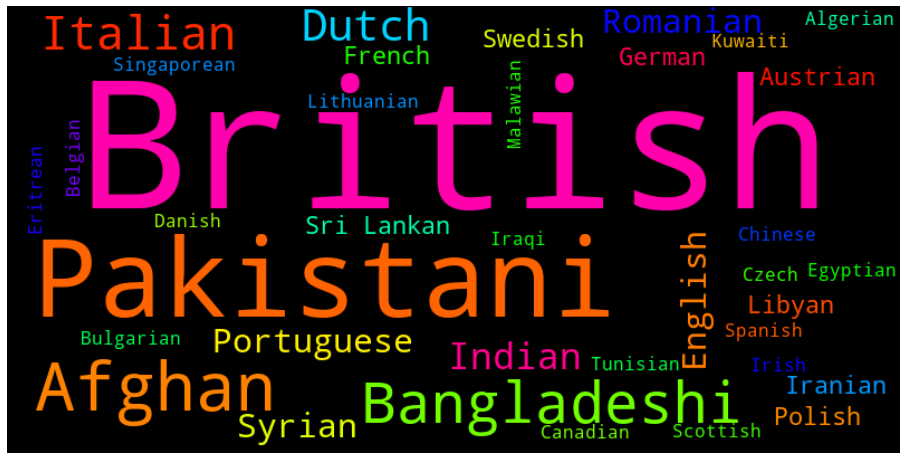

In [47]:
fig3